<a href="https://colab.research.google.com/github/jonahlyn/colab/blob/master/Ruiodoso_Roadway_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ruidoso Roadway Analysis

Count the number of vehicles detected in the Ruidoso camera feed.

## Dependencies

In [1]:
!pip install -q mrcnn

    100% |████████████████████████████████| 61kB 2.4MB/s 


In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
from pathlib import Path

import subprocess as sp
import datetime as dt
import time as tm

import cv2
import numpy as np

import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN

print("OpenCV version: {}".format(cv2.__version__))

OpenCV version: 3.4.3


Using TensorFlow backend.


## MaskRCNN

https://medium.com/@ageitgey/snagging-parking-spaces-with-mask-r-cnn-and-python-955f2231c400

In [0]:
# Configuration that will be used by the Mask-RCNN library
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  # COCO dataset has 80 classes + one background class
    DETECTION_MIN_CONFIDENCE = 0.6

In [0]:
def get_car_boxes(boxes, class_ids):
  '''
  Filter a list of Mask R-CNN detection results to get only the detected cars / trucks
  '''
  car_boxes = []

  for i, box in enumerate(boxes):
      # If the detected object isn't a car / truck, skip it
      if class_ids[i] in [3, 8, 6]:
          car_boxes.append(box)

  return np.array(car_boxes)

In [5]:
# Download the pretrained weights
CURRENT_DIR = Path(".")
MODEL_DIR = os.path.join(CURRENT_DIR, "logs")
MODEL_PATH = os.path.join(CURRENT_DIR, "mask.rcnn.coco.h5")

if not os.path.exists(MODEL_PATH):
  mrcnn.utils.download_trained_weights(MODEL_PATH)

... done downloading pretrained model!


In [6]:
# Create the model to be used for object detection
model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=MaskRCNNConfig())
model.load_weights(MODEL_PATH, by_name=True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


## Data Collection

Grab an image frame from the RTSP stream:

- http://zulko.github.io/blog/2013/09/27/read-and-write-video-frames-in-python-using-ffmpeg/
- https://stackoverflow.com/questions/22003441/streaming-m3u8-file-with-opencv

In [0]:
FFMPEG_BIN = '/usr/bin/ffmpeg'
RTSP_STREAM = "https://590804fbbbc47.streamlock.net:444/ruidosowebcorp2/ruidosowebcorp2.stream/playlist.m3u8"

command = [ FFMPEG_BIN,
            '-i', RTSP_STREAM,
            '-f', 'image2pipe',
            '-pix_fmt', 'rgb24',
            '-vcodec', 'rawvideo', '-']

vwidth = 800
vheight = 450

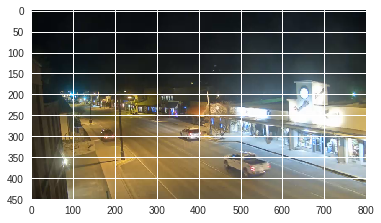

In [8]:
pipe = sp.Popen(command, stdin = sp.PIPE, stdout = sp.PIPE)

raw_image = pipe.stdout.read(vwidth*vheight*3) # read 432*240*3 bytes (= 1 frame)
image =  np.frombuffer(raw_image, dtype='uint8').reshape((vheight,vwidth,3))

plt.imshow(image)
plt.show()

In [0]:
image_copy = image.copy()

In [0]:
# Detect vehicles and draw bounding boxes
results = model.detect([image_copy], verbose=0)
result = results[0]
car_boxes = get_car_boxes(result['rois'], result['class_ids'])

for box in car_boxes:
  y1, x1, y2, x2 = box
  cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0,255,0), 2)

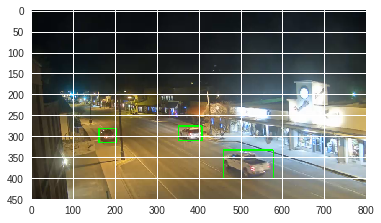

3 vehicles detected in the image


In [11]:
plt.imshow(image_copy)
plt.show()
print("{} vehicles detected in the image".format(len(car_boxes)))

## Save the Output

In [12]:
d = dt.datetime.fromtimestamp(tm.time())
output_img = cv2.cvtColor(image_copy, cv2.COLOR_RGB2BGR)
cv2.imwrite("output_{}.png".format(d.strftime('%Y%m%d%H%M%S')), output_img)

True